In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
import string
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from collections import Counter
from wordcloud import WordCloud
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.util import bigrams

In [42]:
import gensim

ModuleNotFoundError: No module named 'gensim'

In [38]:
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report
from gensim.models import Word2Vec

ModuleNotFoundError: No module named 'gensim'

In [6]:
import json

def parse_data(file):
    for l in open(file, 'r'):
        yield json.loads(l)

data = list(parse_data('../data/Sarcasm_Headlines_Dataset_v2.json'))
df = pd.DataFrame(data)

In [7]:
df

,is_sarcastic,headline,article_link
0,1,thirtysomething scientists unveil doomsday clo...,https://www.theonion.com/thirtysomething-scien...
1,0,dem rep. totally nails why congress is falling...,https://www.huffingtonpost.com/entry/donna-edw...
2,0,eat your veggies: 9 deliciously different recipes,https://www.huffingtonpost.com/entry/eat-your-...
3,1,inclement weather prevents liar from getting t...,https://local.theonion.com/inclement-weather-p...
4,1,mother comes pretty close to using word 'strea...,https://www.theonion.com/mother-comes-pretty-c...
...,...,...,...
28614,1,jews to celebrate rosh hashasha or something,https://www.theonion.com/jews-to-celebrate-ros...
28615,1,internal affairs investigator disappointed con...,https://local.theonion.com/internal-affairs-in...
28616,0,the most beautiful acceptance speech this week...,https://www.huffingtonpost.com/entry/andrew-ah...
28617,1,mars probe destroyed by orbiting spielberg-gat...,https://www.theonion.com/mars-probe-destroyed-...


## Understand the dataset

In [11]:
# overview
df.head()

,is_sarcastic,headline,article_link
0,1,thirtysomething scientists unveil doomsday clo...,https://www.theonion.com/thirtysomething-scien...
1,0,dem rep. totally nails why congress is falling...,https://www.huffingtonpost.com/entry/donna-edw...
2,0,eat your veggies: 9 deliciously different recipes,https://www.huffingtonpost.com/entry/eat-your-...
3,1,inclement weather prevents liar from getting t...,https://local.theonion.com/inclement-weather-p...
4,1,mother comes pretty close to using word 'strea...,https://www.theonion.com/mother-comes-pretty-c...


In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28619 entries, 0 to 28618
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   is_sarcastic  28619 non-null  int64 
 1   headline      28619 non-null  object
 2   article_link  28619 non-null  object
dtypes: int64(1), object(2)
memory usage: 670.9+ KB


In [13]:
df['is_sarcastic'].value_counts()

is_sarcastic
0    14985
1    13634
Name: count, dtype: int64

## Check for missing or duplicated data

In [ ]:
df.isnull().sum() # no missing data

is_sarcastic    0
headline        0
article_link    0
dtype: int64

In [20]:
df.duplicated().sum() # two duplicated rows

np.int64(2)

In [21]:
df = df.drop_duplicates() # remove duplicated data

In [23]:
df.drop('article_link', axis = 1, inplace=True)

/var/folders/8h/9fjqbpx9079dlrvs9qfkn_7r0000gn/T/ipykernel_5152/3666072888.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop('article_link', axis = 1, inplace=True)


In [25]:
translator = str.maketrans('', '', string.punctuation)
df['headline'] = df['headline'].astype(str).str.lower() # lowercase
df['headline'] = df['headline'].apply(lambda x: x.translate(translator)) # remove punctuations
df['token'] = df.apply(lambda row: word_tokenize(row['headline']), axis=1) # tokenization
stop_words = set(stopwords.words('english'))
df['word'] = df['token'].apply(lambda x: [word for word in x if word not in stop_words]) # remove stopwords
df['bigram'] = df['token'].apply(lambda x: list(bigrams(x))) # bigrams
df['bigram_remove'] = df['bigram'].apply(lambda x: [word for word in x if word[0] not in stop_words 
                                                    and word[1] not in stop_words]) # remove bigrams with stop words
df['bigram'] = df['bigram_remove'].apply(lambda x: [' '.join(word) for word in x])
df.drop('bigram_remove', axis=1, inplace=True)

/var/folders/8h/9fjqbpx9079dlrvs9qfkn_7r0000gn/T/ipykernel_5152/3598933835.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['headline'] = df['headline'].astype(str).str.lower() # lowercase
/var/folders/8h/9fjqbpx9079dlrvs9qfkn_7r0000gn/T/ipykernel_5152/3598933835.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['headline'] = df['headline'].apply(lambda x: x.translate(translator)) # remove punctuations
/var/folders/8h/9fjqbpx9079dlrvs9qfkn_7r0000gn/T/ipykernel_5152/3598933835.py:4: SettingWithCop

In [27]:
df

,is_sarcastic,headline,token,word,bigram
0,1,thirtysomething scientists unveil doomsday clo...,"[thirtysomething, scientists, unveil, doomsday...","[thirtysomething, scientists, unveil, doomsday...","[thirtysomething scientists, scientists unveil..."
1,0,dem rep totally nails why congress is falling ...,"[dem, rep, totally, nails, why, congress, is, ...","[dem, rep, totally, nails, congress, falling, ...","[dem rep, rep totally, totally nails, falling ..."
2,0,eat your veggies 9 deliciously different recipes,"[eat, your, veggies, 9, deliciously, different...","[eat, veggies, 9, deliciously, different, reci...","[veggies 9, 9 deliciously, deliciously differe..."
3,1,inclement weather prevents liar from getting t...,"[inclement, weather, prevents, liar, from, get...","[inclement, weather, prevents, liar, getting, ...","[inclement weather, weather prevents, prevents..."
4,1,mother comes pretty close to using word stream...,"[mother, comes, pretty, close, to, using, word...","[mother, comes, pretty, close, using, word, st...","[mother comes, comes pretty, pretty close, usi..."
...,...,...,...,...,...
28614,1,jews to celebrate rosh hashasha or something,"[jews, to, celebrate, rosh, hashasha, or, some...","[jews, celebrate, rosh, hashasha, something]","[celebrate rosh, rosh hashasha]"
28615,1,internal affairs investigator disappointed con...,"[internal, affairs, investigator, disappointed...","[internal, affairs, investigator, disappointed...","[internal affairs, affairs investigator, inves..."
28616,0,the most beautiful acceptance speech this week...,"[the, most, beautiful, acceptance, speech, thi...","[beautiful, acceptance, speech, week, came, qu...","[beautiful acceptance, acceptance speech, week..."
28617,1,mars probe destroyed by orbiting spielberggate...,"[mars, probe, destroyed, by, orbiting, spielbe...","[mars, probe, destroyed, orbiting, spielbergga...","[mars probe, probe destroyed, orbiting spielbe..."


In [28]:
# create a new dataframe of words & number of occurrence
all_words = [word for i in df['word'] for word in i]
count = Counter(all_words)
word_count_df = pd.DataFrame(count.items(), columns = ['word', 'count'])
word_count_df = word_count_df.sort_values(by = 'count', ascending = False)

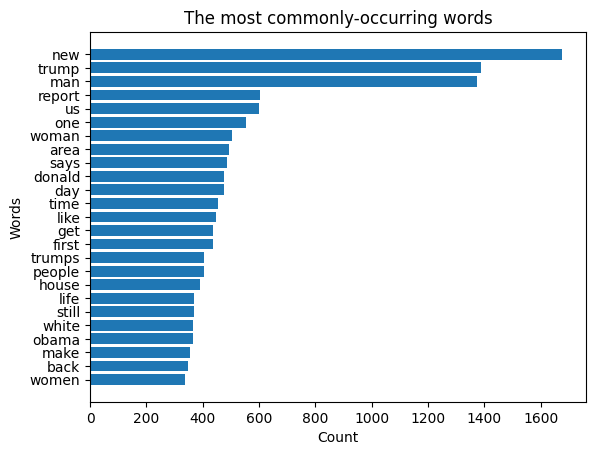

In [29]:
# the most commonly-occurring words
common_word = word_count_df[:25]
plt.barh(common_word['word'], common_word['count'])
plt.title("The most commonly-occurring words")
plt.xlabel("Count")
plt.ylabel("Words")
plt.gca().invert_yaxis()
plt.show()

In [33]:
# create a dataframe of words & count broken by is_sarcastic
words_sarcastic = []
words_not_sarcastic = []
for index, row in df.iterrows():
    if row['is_sarcastic'] == 1:
        for w in row['word']:
            words_sarcastic.append(w)
    elif row['is_sarcastic'] == 0:
        for w in row['word']:
            words_not_sarcastic.append(w)
count_sarcastic = Counter(words_sarcastic)
words_sarcastic_df = pd.DataFrame(count_sarcastic.items(), columns = ['word', 'count'])
words_sarcastic_df = words_sarcastic_df.sort_values(by = 'count', ascending = False)
count_not_sarcastic = Counter(words_not_sarcastic)
word_not_sarcastic_df = pd.DataFrame(count_not_sarcastic.items(), columns = ['word', 'count'])
word_not_sarcastic_df = word_not_sarcastic_df.sort_values(by = 'count', ascending = False)

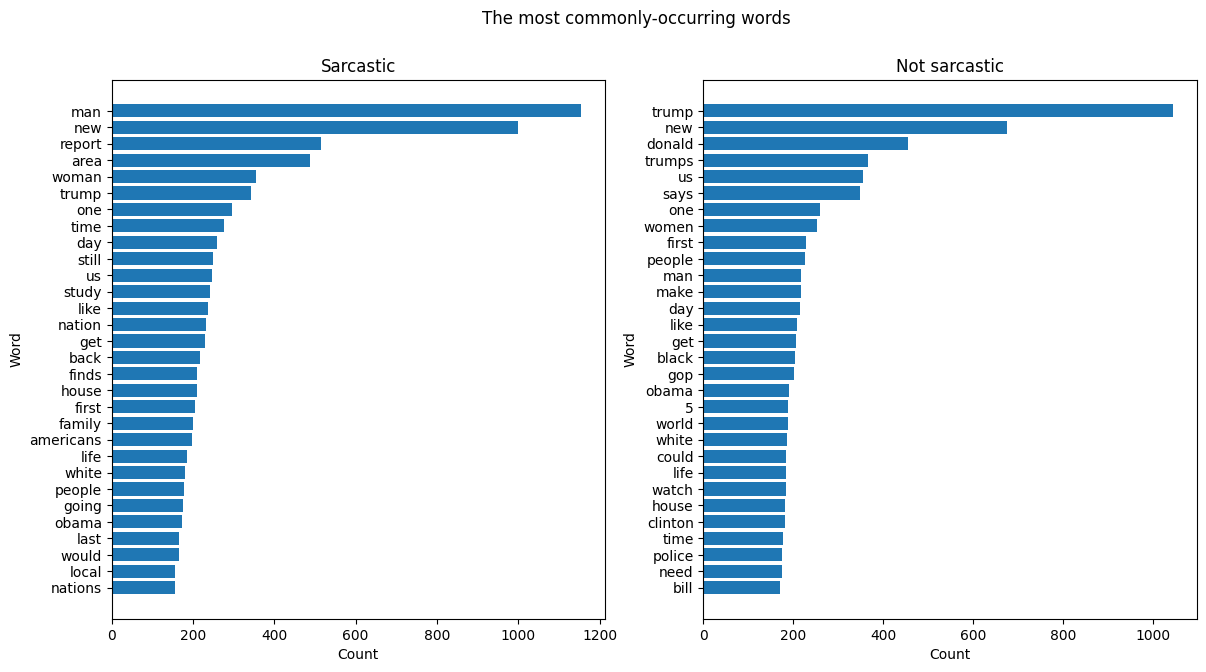

In [35]:
# the most commonly-occurring words, broken down by label
common_words_sarcastic = words_sarcastic_df[:30]
common_words_not_sarcastic = word_not_sarcastic_df[:30]
fig, axs = plt.subplots(1, 2)
fig.set_figheight(7)
fig.set_figwidth(14)
axs[0].barh(common_words_sarcastic['word'], common_words_sarcastic['count']) # positive
axs[0].invert_yaxis()
axs[0].set_xlabel("Count")
axs[0].set_ylabel("Word")
axs[1].barh(common_words_not_sarcastic['word'], common_words_not_sarcastic['count']) # negative
axs[1].invert_yaxis()
axs[1].set_xlabel("Count")
axs[1].set_ylabel("Word")
fig.suptitle("The most commonly-occurring words")
axs[0].title.set_text('Sarcastic')
axs[1].title.set_text('Not sarcastic')
plt.show()